# MTH 452 Data Science Final Project
---

Dataset: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data

Project from Fall 2021, finally got around to putting it on github. This was my first project involving ML and related concepts.

In [1]:
import pandas as pd
import numpy as np
import klib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('./vehicles.csv')

#### klib cleaning

In [2]:
data = klib.data_cleaning(data)

Shape of cleaned data: (426880, 25) - Remaining NAs: 1228456


Dropped rows: 0
     of which 0 duplicates. (Rows (first 150 shown): [])

Dropped columns: 1
     of which 0 single valued.     Columns: []
Dropped missing values: 426880
Reduced memory by at least: 45.96 MB (-54.27%)



In [3]:
data_clean = data.copy()

#The Cleaning Process


---


In no particular order, here are things I need to fix:


1.   Odemeter max is insane, absolutely need to deal with outliars
2.   Long/lat might need to be standardized, or done away with completely. Location data would be cool but i need to figure out how accurate it is and where its all coming from. Random numbers probably won't help
3.   ID needs to be taken out
4.   standardize year
5.   can i find another dataset that describes vehicles year/make/model that gives type, size, and cylinders information?
6.   can i use VIN number to fill in missing data?



Current biggest points of missing data are:    
size, type, paint, drive, cylinders, condition







In [4]:
data_clean.tail()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
426875,7301591192,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00o0o_iiraFnHg8q...,Carvana is the safer way to buy a car During t...,wy,33.786499,-84.445396,2021-04-04T03:21:31-0600
426876,7301591187,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,...,fwd,NaN,sedan,red,https://images.craigslist.org/00x0x_15sbgnxCIS...,Carvana is the safer way to buy a car During t...,wy,33.786499,-84.445396,2021-04-04T03:21:29-0600
426877,7301591147,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,...,NaN,NaN,hatchback,white,https://images.craigslist.org/00L0L_farM7bxnxR...,Carvana is the safer way to buy a car During t...,wy,33.779213,-84.411812,2021-04-04T03:21:17-0600
426878,7301591140,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,...,fwd,NaN,sedan,silver,https://images.craigslist.org/00z0z_bKnIVGLkDT...,Carvana is the safer way to buy a car During t...,wy,33.786499,-84.445396,2021-04-04T03:21:11-0600
426879,7301591129,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,...,rwd,NaN,coupe,NaN,https://images.craigslist.org/00Y0Y_lEUocjyRxa...,Carvana is the safer way to buy a car During t...,wy,33.779213,-84.411812,2021-04-04T03:21:07-0600


GridSpec(6, 6)

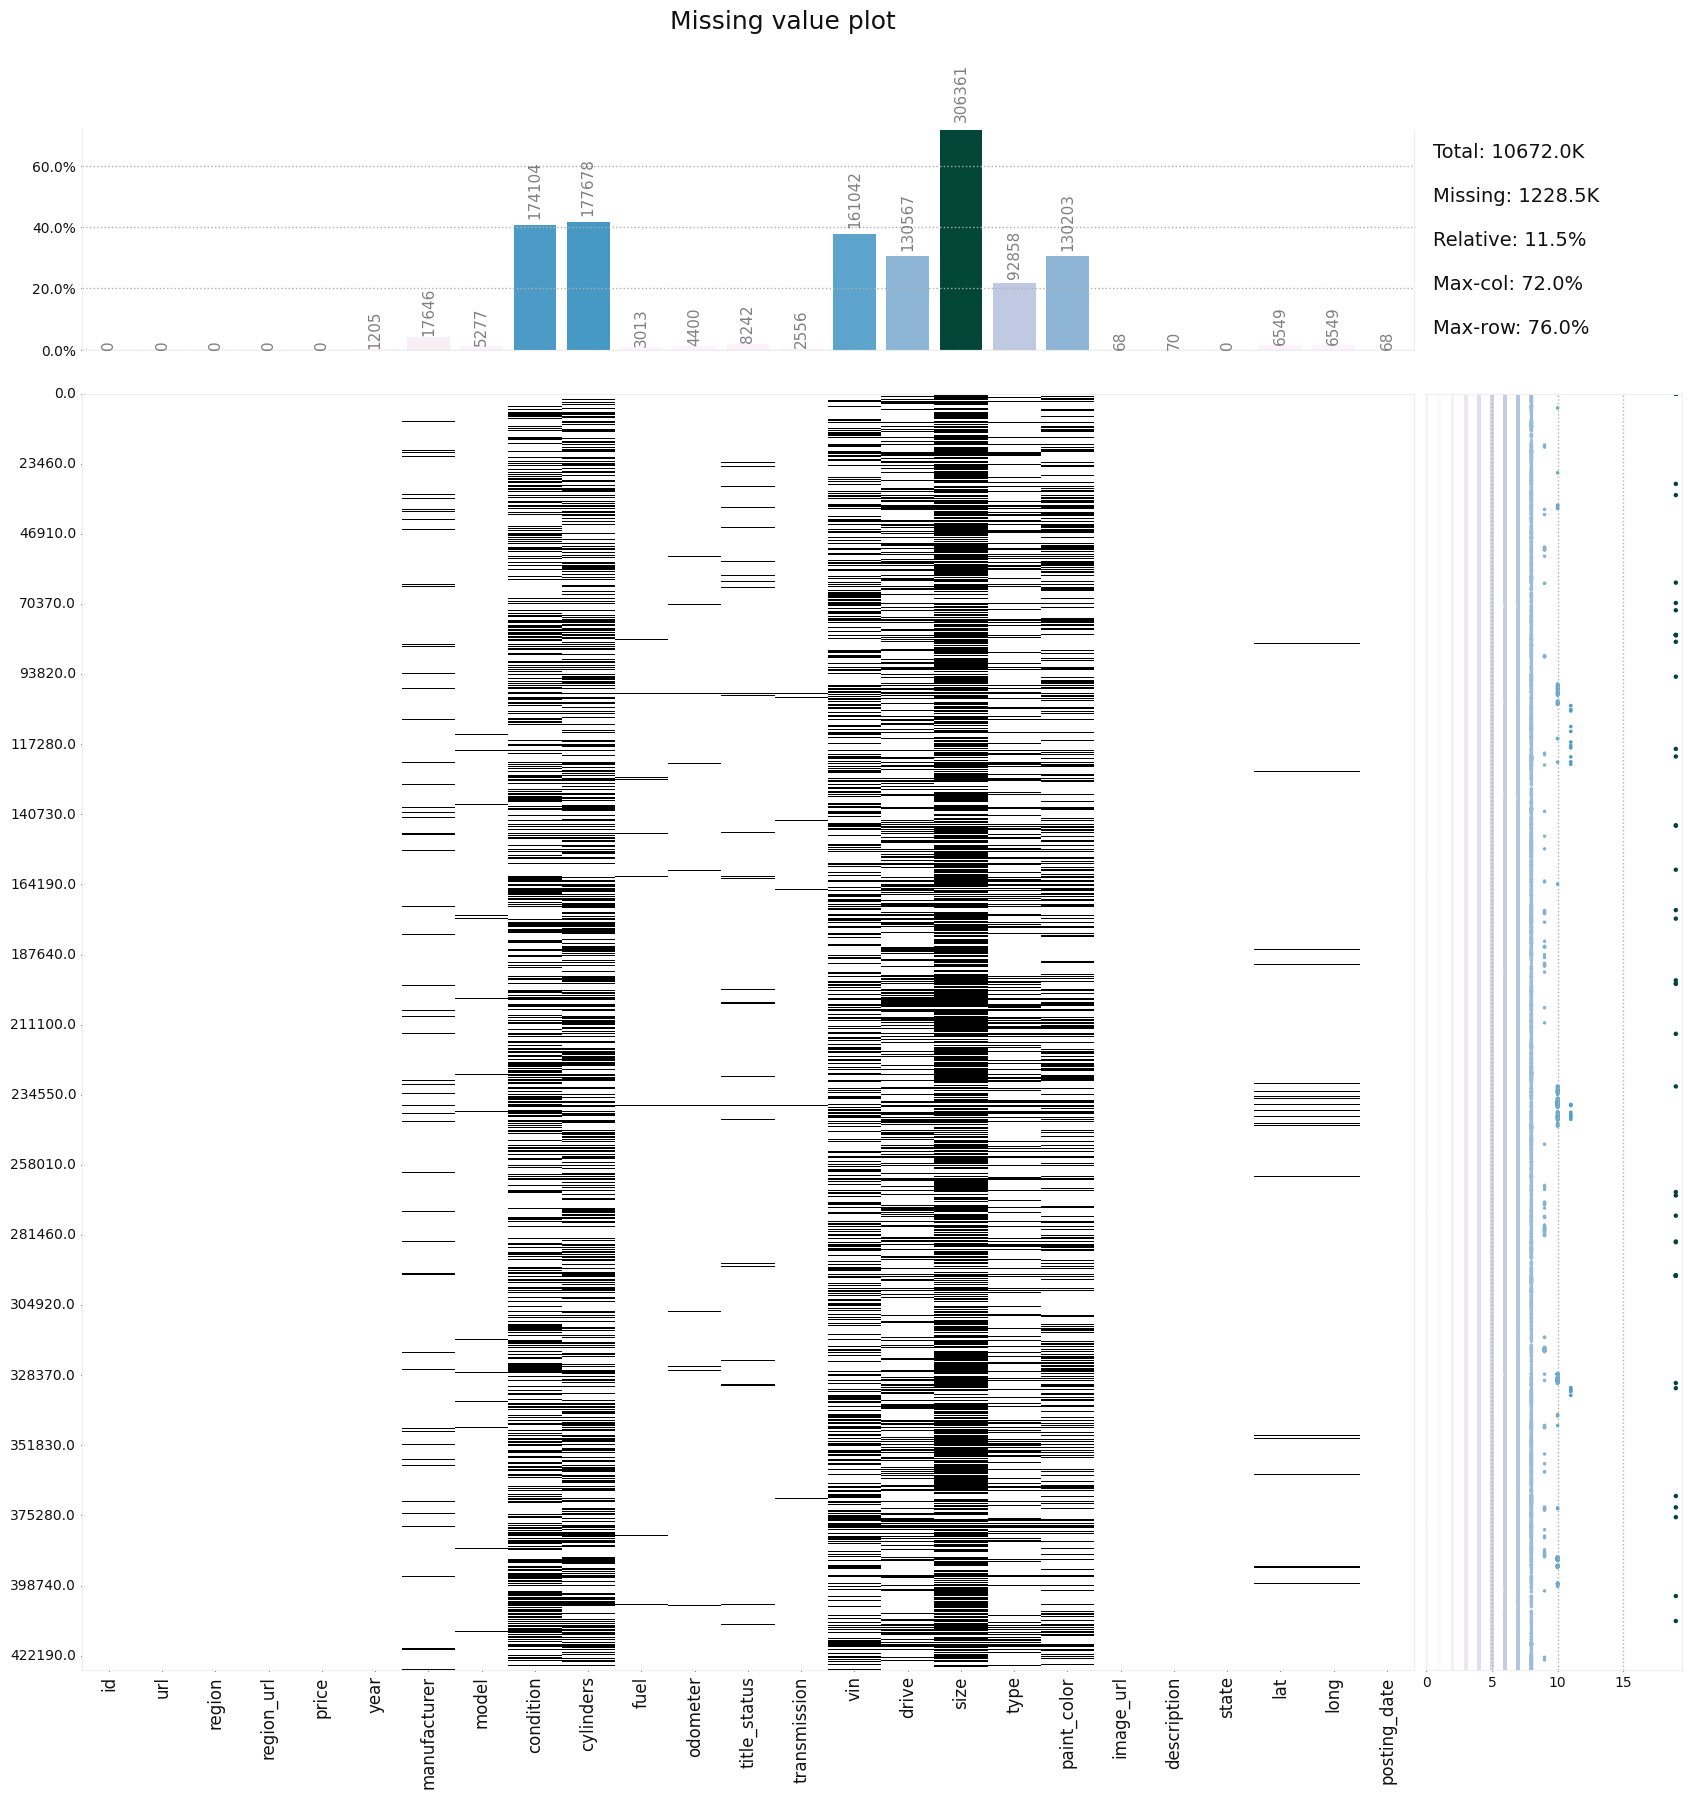

In [5]:
klib.missingval_plot(data_clean)

Starting off, I am removing columns that fit within two categories:


1.   Are special to each listing (i.e. url, region_url, vin, paint_color, id, etc)
2.   Provide very little information or just don't fit well to a model. Such examples are state (long/lat can provide that info while reducing the complexity of vectors), paint_color (too much missing), size (too much missing), etc


Now I'm dropping rows that contain missing values. I left out some on purpose due to an excess of missing data (fixed later). For now, these rows are being dropped based on na values in columns that contain otherwise very few missing data points. For instance, what year the vehicle was made only is only missing 1.2k values. These are dropped to make things easier.

In [6]:
# Dropping a whole bunch of data, either too difficult to process or not relevant information,
data_clean = data_clean.drop(columns=['url', 'region_url', 'vin', 'image_url', 'description', 'id', 'size', 'paint_color', 'posting_date','region','state'])

# Then dropping rows containing na values in columns that are missing very little data
data_clean = data_clean.dropna(axis=0, subset=['manufacturer', 'model', 'year', 'odometer', 'title_status', 'lat', 'long', 'transmission', 'fuel'])

In [7]:
data_clean.describe()

,price,year,odometer,lat,long
count,3.834890e+05,383489.000000,3.834890e+05,383489.000000,383489.000000
mean,6.478803e+04,2011.567871,9.662315e+04,38.524929,-94.589714
std,1.153956e+07,8.682616,1.927812e+05,5.827518,18.300381
min,0.000000e+00,1900.000000,0.000000e+00,-81.838234,-159.827728
25%,5.999000e+03,2008.000000,3.800000e+04,34.720001,-111.841591
50%,1.399800e+04,2014.000000,8.598600e+04,39.169998,-88.323540
75%,2.688800e+04,2017.000000,1.340000e+05,42.430801,-80.824615
max,3.736929e+09,2022.000000,1.000000e+07,82.252823,173.885498


Clearly there are areas of poor data in this dataset. For instance, there is a maximum price in excess of 3.7 billion, or another being 10 million miles. To rectify these mistakes, I'm starting by dropping all values that fall a significant distance from the mean in the odometer, latitude, longitude, and price categories. The area I am dropping here is intentionally excessively far away. The point of this step is not to exclude outliers, but instead get rid of misinputs in numerical categories

In [8]:
columns = pd.Series(['odometer', 'lat', 'long', 'price','year']) # dropping class, time, and amount
origLen = len(data_clean)

for column in columns:
  firstQ, thirdQ = data_clean[column].quantile([.25, .75])        # finds quartiles so I can calculate IQR and from there cutoff points to
  iqr = (thirdQ - firstQ) * 10                                    # Subject to change if it cuts off too much data
  lowerCutoff, upperCutoff = firstQ - iqr, thirdQ + iqr

  # creates (and drops) a new dataframe that has data exceeding the upper and lower bounds
  data_clean = data_clean.drop(data_clean[(data_clean[column] > upperCutoff) | (data_clean[column] < lowerCutoff)].index)

afterLen = len(data_clean)
print(origLen-afterLen, 'values have been removed')

466 values have been removed


In [9]:
data_clean['model'].value_counts()

f-150                7486
silverado 1500       4732
1500                 4128
camry                3041
silverado            2932
                     ... 
superior coach          1
q45t 1998               1
2500 crew cab 4wd       1
pathfinder 4dr sv       1
gand wagoneer           1
Name: model, Length: 21744, dtype: Int64

In this dataset we are dealing with peoples inputs, which have no guarantee of being identical or even accurate. Below, we see that there are over 20,000 unique models in this dataset. Considering this dataset is dealing with ~400k cars, 20k+ different models is substantial. Infact, most of these are one-of instances. The goal of the next step is to remove model names that appear very few times in the dataset. To reduce the number number of unique models as much as possible, I am deleting all models that appear less than 100 times

In [10]:
print(len(data_clean['model'].value_counts()), 'unique models')

21744 unique models


In [11]:
# This chunk of code removes car models that appear under ten times. Models in this category don't have enough data to be predicted

removeVals = pd.Series(data_clean['model'].value_counts() > 100) # makes a true/false column for the unique models that occur more than 5 times

modelRM = removeVals[data_clean['model']] # applied the true/false column to rows in the model row

data_clean.insert(7, 'removeColumn', modelRM.values) # inserts the column

data_clean = data_clean[data_clean['removeColumn'] == True] # selects rows that have modelRM value as True as a part of the new data_clean

data_clean = data_clean.drop(columns=['removeColumn']) # drops our T/F column

In [12]:
print(len(data_clean['model'].value_counts()), 'unique models after removing rare models')

620 unique models after removing rare models


As you can see, the number of unique models was reduced from 21,000 to 620.

A side effect of this change is that some manufacturers now contain no vehicles. Ferrari for instance is clearly a more exotic brand. The dataset did not contain 100+ Ferraris, but the name still exists as a category. To fix this, all manufacturers that aren't used are now removed

In [13]:
# Doing the previous step left multiple manufacterers without vehicles. There's no point leaving them in the dataset, so they will be removed
data_clean['manufacturer'] = data_clean['manufacturer'].cat.remove_unused_categories()

#Numerical Data and Logic Errors


---


Dealing with specific logic errors and such in numerical categories

####Price

Cleaning up the price category. In summary this is removing impossible values (below 0) and finding a cutoff point for price

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


/home/msaad/miniconda3/envs/temp/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Axes: xlabel='price', ylabel='Density'>

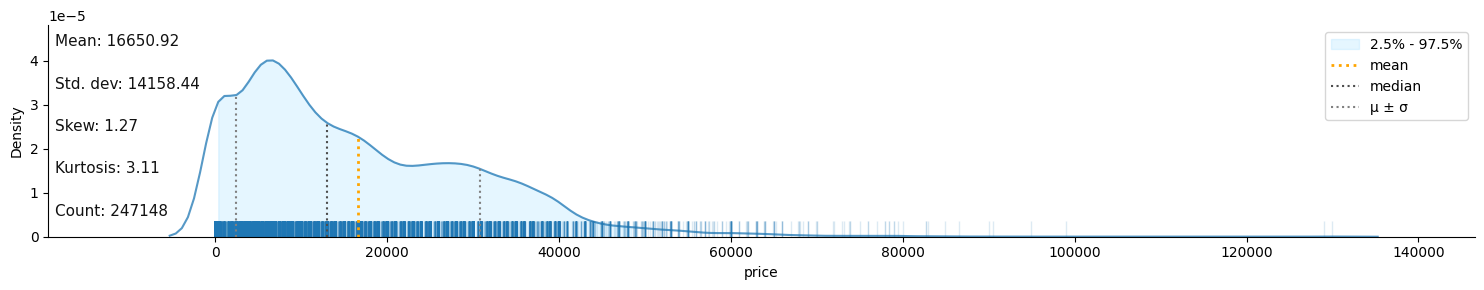

In [14]:
klib.dist_plot(data_clean['price'])

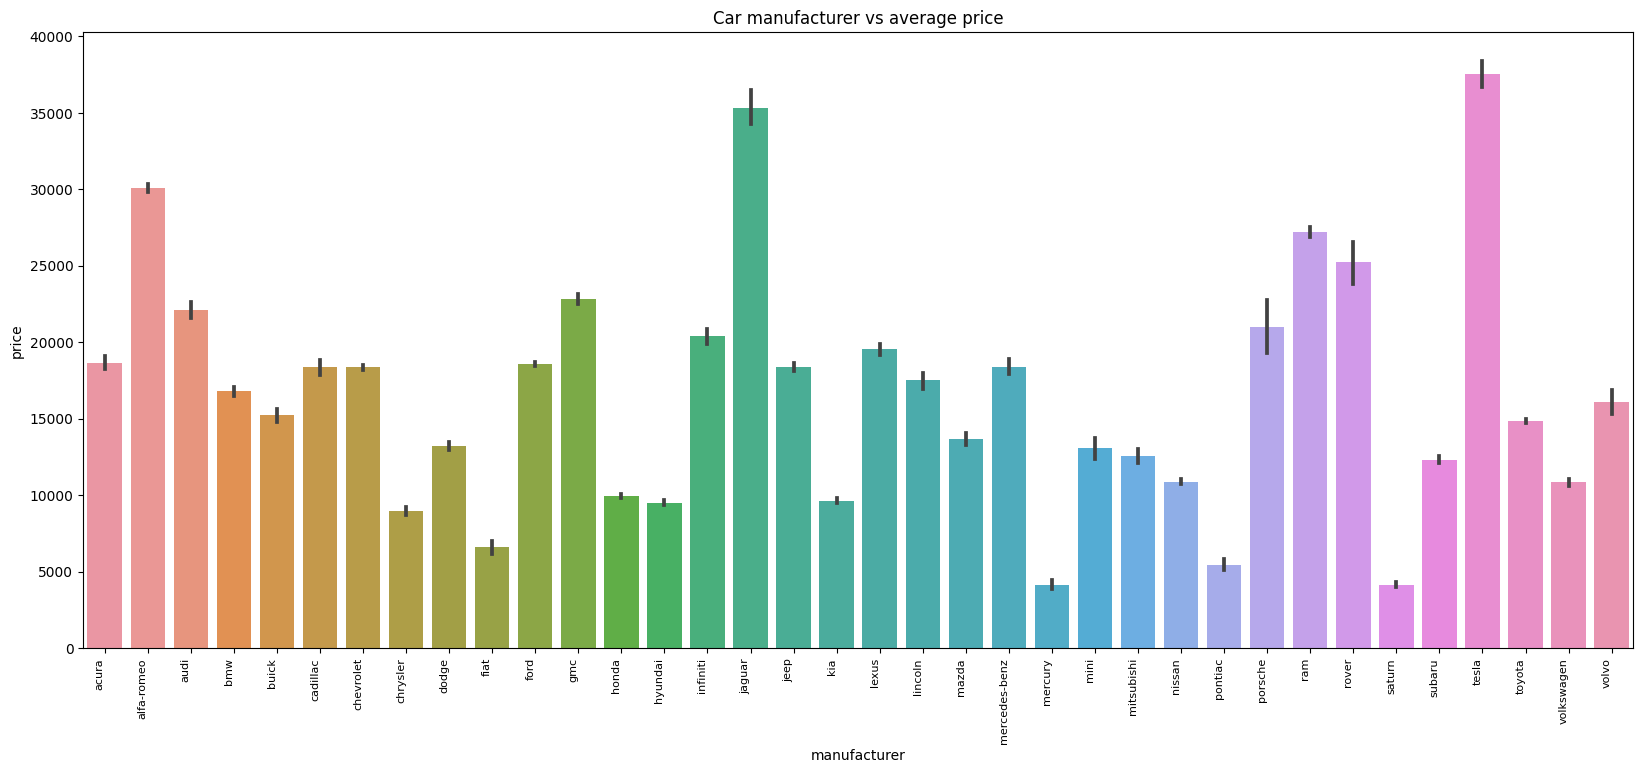

In [15]:
# Inspiration for this was found on kaggle
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
ax = sns.barplot(x='manufacturer', y='price', data=data_clean);
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right",fontsize=8);
plt.title("Car manufacturer vs average price");

For now, I'm going to drop all prices that are above \$100,000. The above barplot illustrates nicely that the average prices for most manufacturers isn't even above \$30,000, so anything above 100k is an extreme outlier.

Additionally, any prices that are below \$0 are also being deleted since clearly we can't sell cars for under \$0

In [16]:
print('Number below 0:', len(data_clean[data_clean.price < 0]))
print('Number above 100k:', len(data_clean[data_clean.price > 100_000]))

Number below 0: 0
Number above 100k: 103


In [17]:
# Removing such values from the dataset
data_clean = data_clean[data_clean.price < 100_000]
data_clean = data_clean[data_clean.price > 0]

In [18]:
data_clean.describe().loc[['max','min'],'price']

max    99999.0
min        1.0
Name: price, dtype: float64

#### Year

The year values have already had misinputs removed, or atleast very obvious ones in the previous steps. The concern here is removing very old (or 'classics') vehicles. Such vehicles could heavily influence the model due to their value oftentimes appreciating

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


/home/msaad/miniconda3/envs/temp/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Axes: xlabel='year', ylabel='Density'>

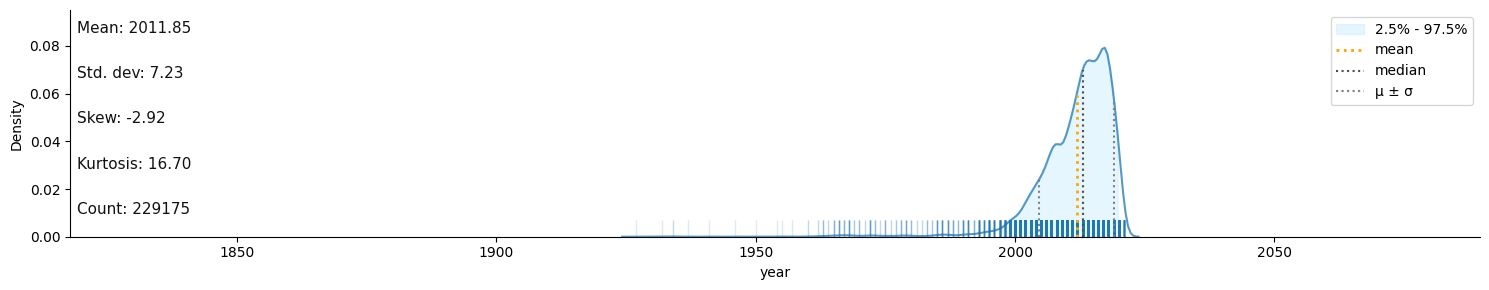

In [19]:
klib.dist_plot(data_clean['year'])

In [20]:
print(data_clean['year'].value_counts().tail(40).sum(), 'cars from 1918-1958')

740 cars from 1918-1958


Here we see that in the years from 1918 to 1958, our dataset only contains 1056 cars. These will be dropped to make a cleaner distribution


Similarily, any vehicles that claim to be made after 2022 are also removed since this dataset should not contain any 2023 and upwards

In [21]:
data_clean = data_clean.drop(data_clean[(data_clean['year'] < 1958) | (data_clean['year'] > 2022)].index)

#### Odometer
Seeing the distribution plot below, it's obvious we have values well in excess of what most vehicles are. Data points exist above 600,000 miles, and some even in excess of 1 million. Such points would not contribute to a better model, so I will be drawing a line at 400,000 miles. Any data falling outside the range 0-400,000 will be removed

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


/home/msaad/miniconda3/envs/temp/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Axes: xlabel='odometer', ylabel='Density'>

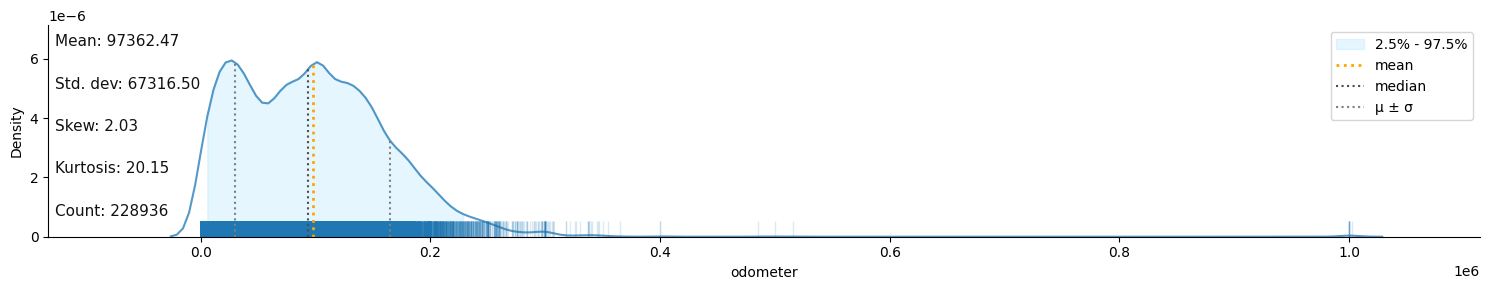

In [22]:
klib.dist_plot(data_clean['odometer'])

In [23]:
data_clean = data_clean.drop(data_clean[(data_clean['odometer'] > 400_000)].index)

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


/home/msaad/miniconda3/envs/temp/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Axes: xlabel='odometer', ylabel='Density'>

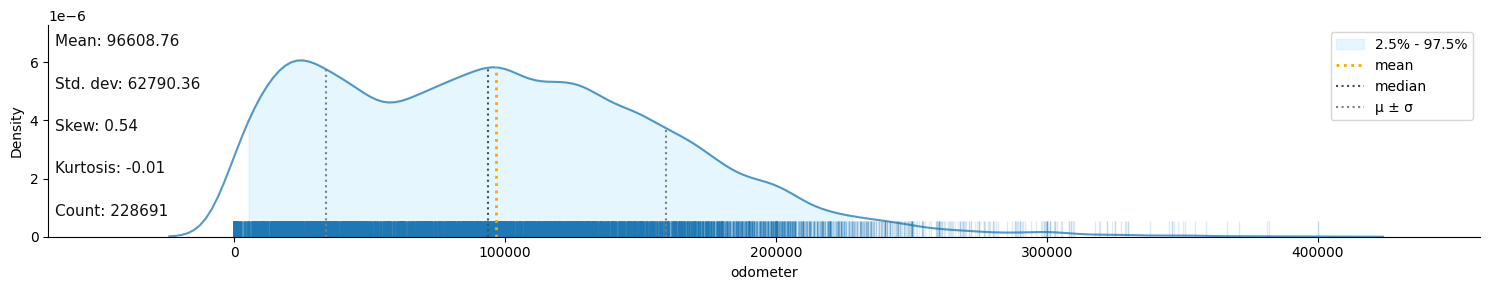

In [24]:
klib.dist_plot(data_clean['odometer'])

#### Latitude/Longitude

First, since this data is supposed to only be compiled of vehciles within the United States, I am going to drop all long/lat values that lie outside the U.S. Those values are: 25 < Lat < 49, and -125 < Long < -67.


Also, I saw a map on kaggle I thought was awesome. From the map we can easily see most of the data comes from the Eastern side of the united states. I thought it was quite cool to see the density of cars being sold follows almost exactly the pattern of population density. If your interested in a map of population density, I've left a link below
http://dhmontgomery.com/2018/02/population-latitude/

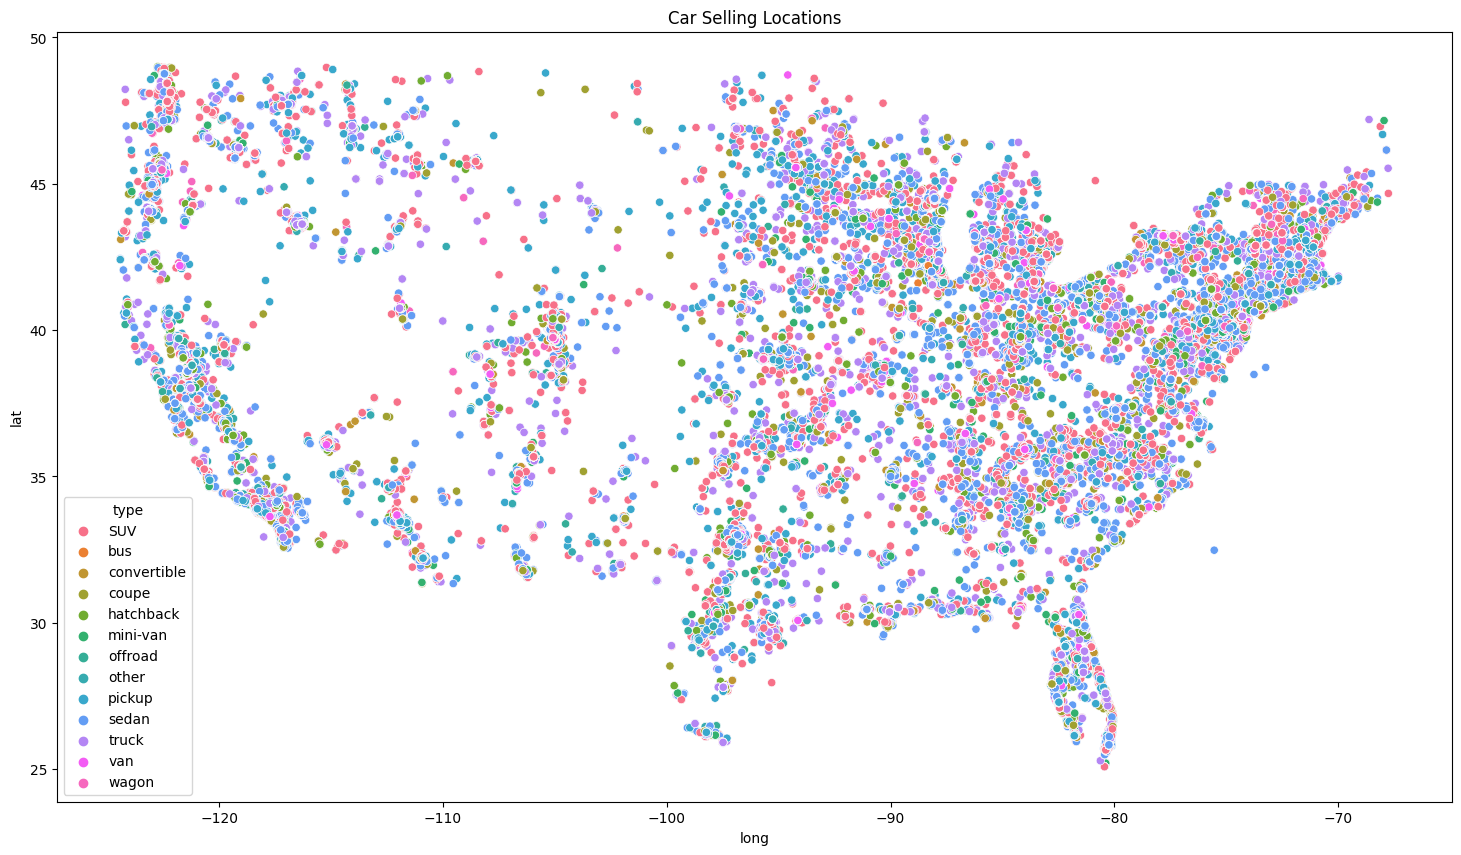

Number of Rows Deleted: 3617


In [25]:
lenBefore = len(data_clean)
# Redefines dataset to the data falling within the U.S. (excluding Hawaii and Alaska)
data_clean = data_clean[(data_clean['lat']>25) & (data_clean['lat']<49) & (data_clean['long']>-125) & (data_clean['long']<-67)]

plt.figure(figsize=(18,10))
plt.title('Car Selling Locations')
sns.scatterplot(data=data_clean, x="long", y="lat", hue='type')
plt.show()
print('Number of Rows Deleted:', lenBefore-len(data_clean))

3617 rows were deleted after removing those outside the mainland of the United States. We do see some scattered points falling in the ocean but they will be left seeing as there are so few

# Categorical Data and Filling Missing Values
---
Earlier, in the first few lines I dropped many rows that contained missing values in overwelmingly filled columns. Here, I am dealing with the four columns that have far too much missed, but are also too important to be deleted. Those are:
- Type
- Condition
- Drivetrain
- Cylinders

Seen in the plot below two of these categories are reaching 40% of their data missing. The other two sit between 20 and 30 percent. So if I dropped the data that had missing values, I would be sitting with roughly 50% of my data to work with. Even at this point I still have an abundance of available data (ballpark of 225,000), so while I could drop it and still probably come up with an accurate model (perhaps more accurate), I didn't want to.

I tried a couple solutions to this one, with varying degrees of success:
1.  Originally, I wanted to intelligently guess what the missing values were with some generalizations. For instance, I could say vehicles with under 50,000 miles were in excellent condition. Or if the type of the vehicle was a truck, then it has 8 cylinders. That ended up being a bit too difficult to make work.

2.  The next attempt was to just generalize all the missing values to be the same value as the most common value (An average for categories more or less). That worked, and I scored some 88-89% accuracy in the price model, but I found better success with my third and final attempt.

3.  What I've got now, is a Random Forest Classifier to fill in these values. See the code for accuracy on each variable specifically. I chose Random Forest simply for the fact it performed better than the rest of the classifiers. I had logistic regression, and decision trees as the other two I tried but it was obvious Random Forest worked the best

GridSpec(6, 6)

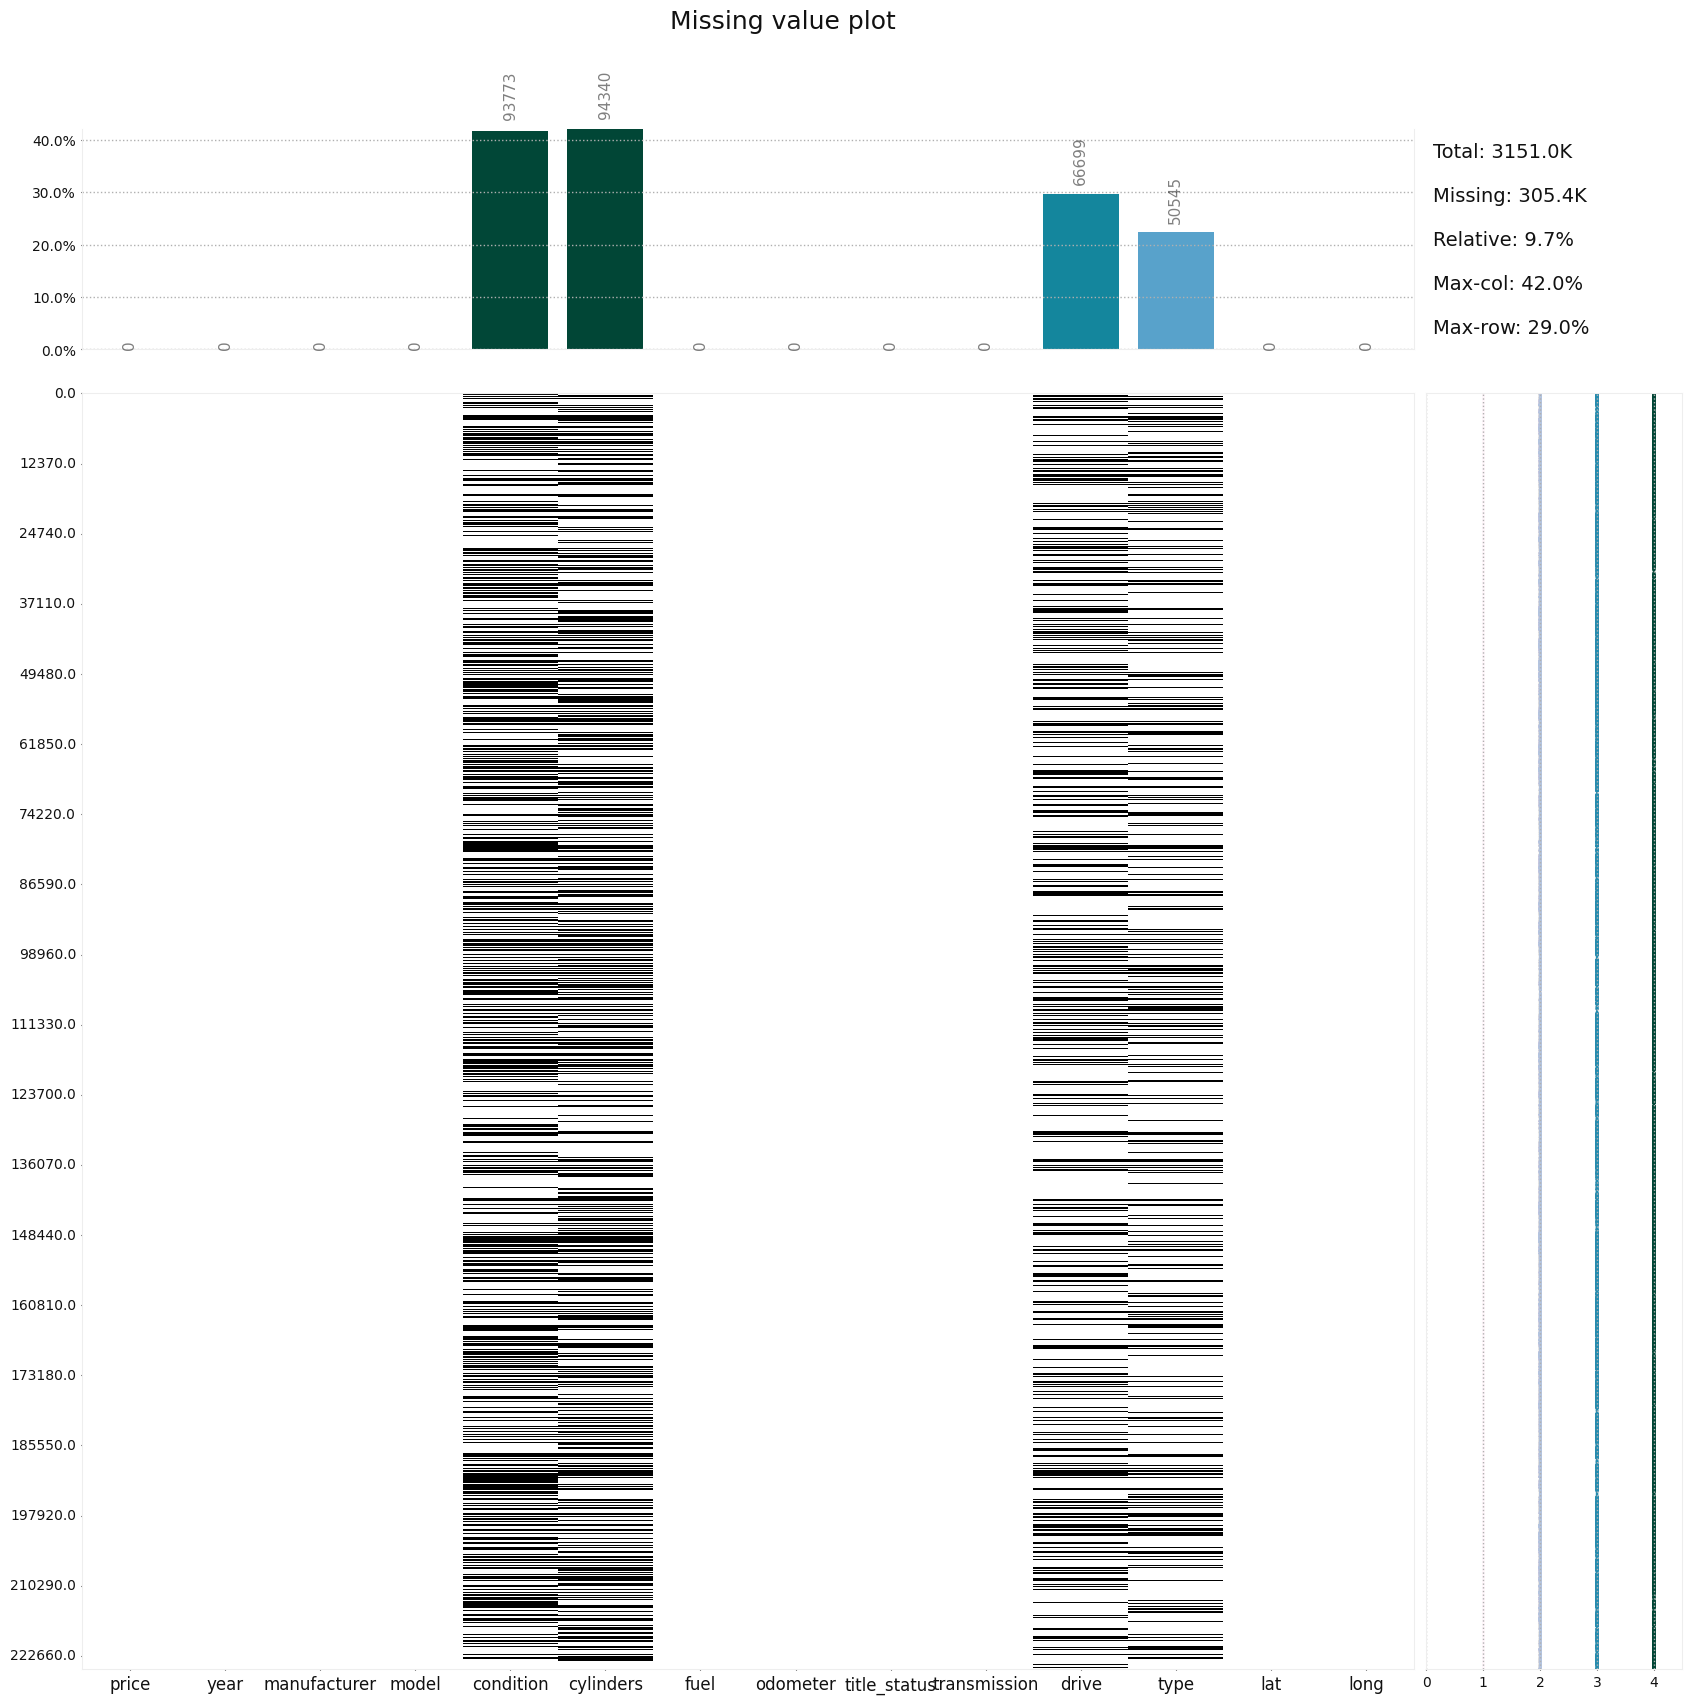

In [26]:
klib.missingval_plot(data_clean)

In [27]:
# Changes all categorical variables into integers so the model can understand the target variables correctly
data_clean['model'] = data_clean['model'].astype('category')

categorical = [
               'fuel', 'title_status', 'transmission','manufacturer','model','type','condition','cylinders','drive'
]

data_clean[categorical] = data_clean[categorical].apply(lambda x: x.cat.codes)

In [28]:
# After the convertion from categorial to integer type, previously null values are now depicted by -1
findValsList = [
                'type', 'condition', 'drive', 'cylinders'
]

for name in findValsList:
  # Establish a set of data that does not contain null values
  noNullCol = data_clean[data_clean[name] != -1]

  # Separate X and Y
  col_X = noNullCol.drop(name, axis=1)
  col_y = noNullCol[name]

  # Now we have to separate a training from testing set, to get a benchmark for roughly how accurate it is
  X_train, X_test, y_train, y_test = train_test_split(col_X, col_y, test_size=0.15)

  # Loops through different models, will likely delete many from list so program doesn't take excessive amounts of time to run
  models = [ RandomForestClassifier() ]

  for model in models:
    classifier = model
    classifier.fit(X_train, y_train)

    # Accuracy
    print(round(classifier.score(X_test,y_test)*100,2), '% Accuracy on the column:', name)

  # Now retreive the null (or in this case -1) from the dataframe, then assign new predicted values
  nullCol_X = data_clean.loc[data_clean[name] == -1].drop(name, axis=1)
  nullCol_y = pd.Series(classifier.predict(nullCol_X))

  # I couldn't get the Series to add since the index of nullCol_X follows that of data_clean, and null_Col_y follows an absolute integer position (since it was just generated)
  # To rectify this issue, I added nullCol_y to nullCol_X as a list
  nullCol_X[name] = nullCol_y.tolist()

  # At this point, nullCol_X no longer has any null values in the column of interest (they've been replaced by predictions). Next step is changing the old values
  data_clean.loc[data_clean[name] == -1] = nullCol_X

90.96 % Accuracy on the column: type
80.96 % Accuracy on the column: condition
93.05 % Accuracy on the column: drive
93.6 % Accuracy on the column: cylinders


In [29]:
# Notice unlike previously, describe shows the categorical variabels too
data_clean.head()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,lat,long
27,33590,2014.0,11,474,2,6,2,57923.0,0,2,0,8,32.590000,-85.480003
28,22590,2010.0,6,489,2,6,2,71229.0,0,2,0,8,32.590000,-85.480003
29,39590,2020.0,6,490,2,6,2,19160.0,0,2,0,8,32.590000,-85.480003
30,30990,2017.0,33,575,2,6,2,41124.0,0,2,0,8,32.590000,-85.480003
31,15000,2013.0,10,229,0,5,2,128000.0,0,0,2,10,32.591999,-85.518898


In [30]:
# Note, no values are below 0 anymore (-1 is a null value)
data_clean.describe()

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,lat,long
count,225074.000000,225074.000000,225074.000000,225074.000000,225074.000000,225074.000000,225074.000000,225074.000000,225074.000000,225074.000000,225074.000000,225074.000000,225074.000000,225074.000000
mean,17846.608000,2011.906738,15.064015,303.710540,0.961924,4.546669,2.029390,97017.171875,0.134711,0.325320,0.694976,6.009357,38.455265,-92.573784
std,13691.956862,6.871864,9.789378,179.349984,1.101222,1.235578,0.689334,62833.156250,0.747460,0.704684,0.712165,4.014915,5.223012,16.159418
min,1.000000,1958.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.080000,-124.426300
25%,6995.000000,2009.000000,7.000000,148.000000,0.000000,3.000000,2.000000,42830.000000,0.000000,0.000000,0.000000,0.000000,34.983566,-104.823112
50%,14450.000000,2013.000000,11.000000,295.000000,0.000000,5.000000,2.000000,94035.000000,0.000000,0.000000,1.000000,8.000000,39.337093,-86.945389
75%,26900.000000,2017.000000,24.000000,472.000000,2.000000,6.000000,2.000000,140000.000000,0.000000,0.000000,1.000000,9.000000,42.370586,-80.652397
max,99999.000000,2022.000000,35.000000,619.000000,5.000000,7.000000,4.000000,400000.000000,5.000000,2.000000,2.000000,12.000000,48.999989,-67.143303


#General EDA

I would like to find a better way to show correlation between the categorical variables, but I haven't figured out how yet.


<Axes: title={'center': 'Feature-correlation (pearson)'}>

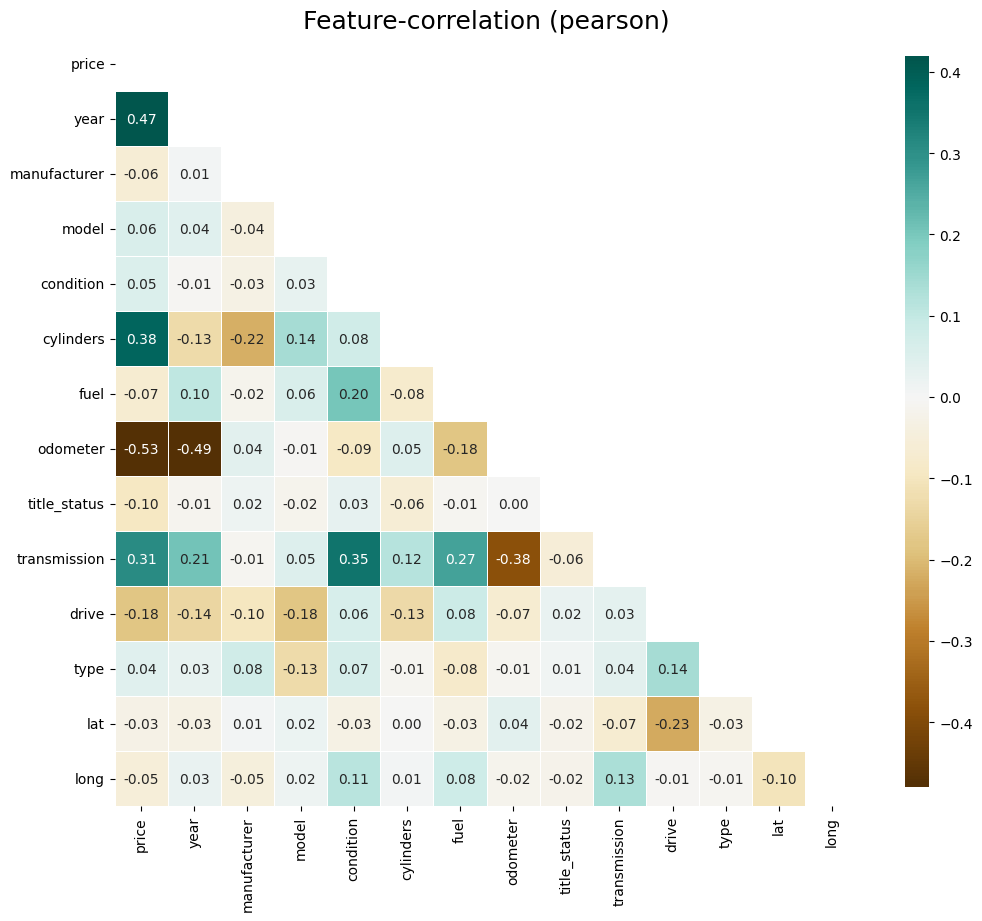

In [31]:
klib.corr_plot(data_clean)

There are some very interesting correlations revealed here, and other expected ones.

These are fairly self explanitory correlations
*   the older a car is the higher it's mileage
*   Transmission/year, is due to automatics taking over the industry.
*   Cylinders and year is not surprising but certainly an interesting find. Over time, manufacturers have been resorting to lower displacement (and by association, cylinder) engines to meet emission standards

STRONGEST CORRELATIONS\:    
* price/odometer @-0.53
* year/odometer @-0.49
* year/price @0.47
* transmission/price @0.31
* condition/transmission @0.35
* odometer/transmission @-0.38

One of the more interesting correlations in this mix is how much transmission correlates with price. It makes sense obviously, since base model cars often come with manuals, and luxury vehicles hardly ever do, but 0.31 was far stronger than I anticipated

I'm disappointed with how much correlation is being seen between manufacturer, model, and condition. I expected that to be much higher. Although worth noting is that could be a fault of the correlation calculation not playing nice with categorical variables. This could also be a result of the amount of models available. At the very least, we should expect some correlation between manufacturer and model.

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


/home/msaad/miniconda3/envs/temp/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/msaad/miniconda3/envs/temp/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/msaad/miniconda3/envs/temp/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/msaad/miniconda3/envs/temp/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/msaad/miniconda3/envs/temp/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/msaad/miniconda3/envs/temp/lib/python3.11/site-packages/seaborn/axisgrid.p

<Axes: xlabel='long', ylabel='Density'>

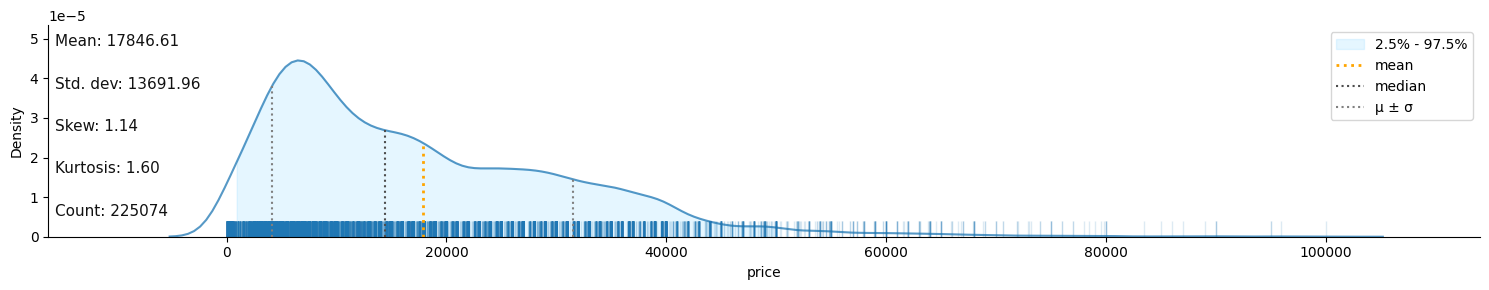

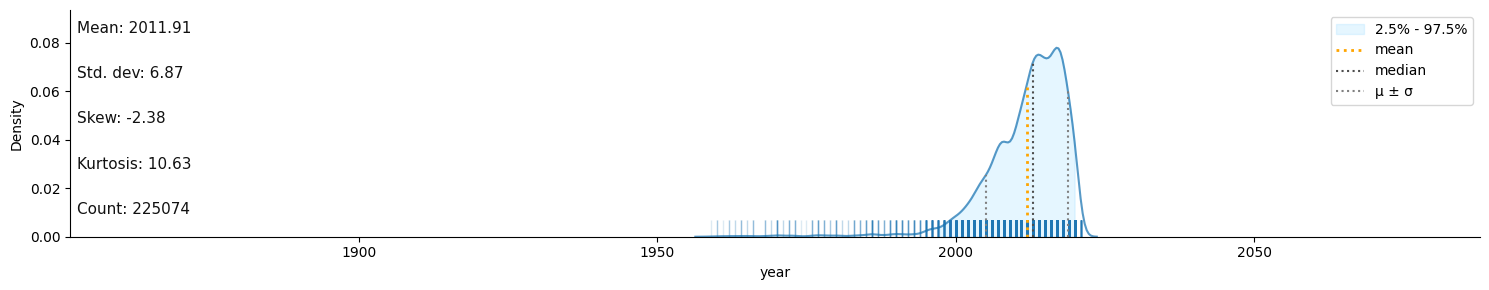

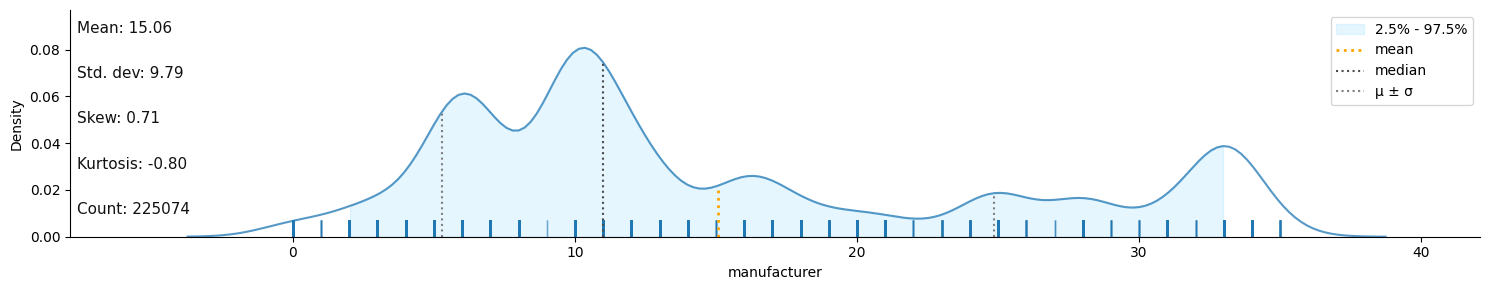

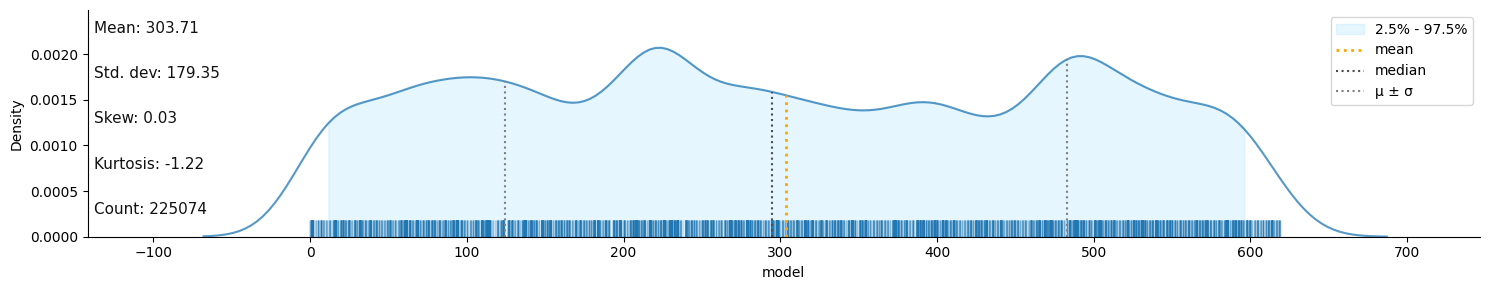

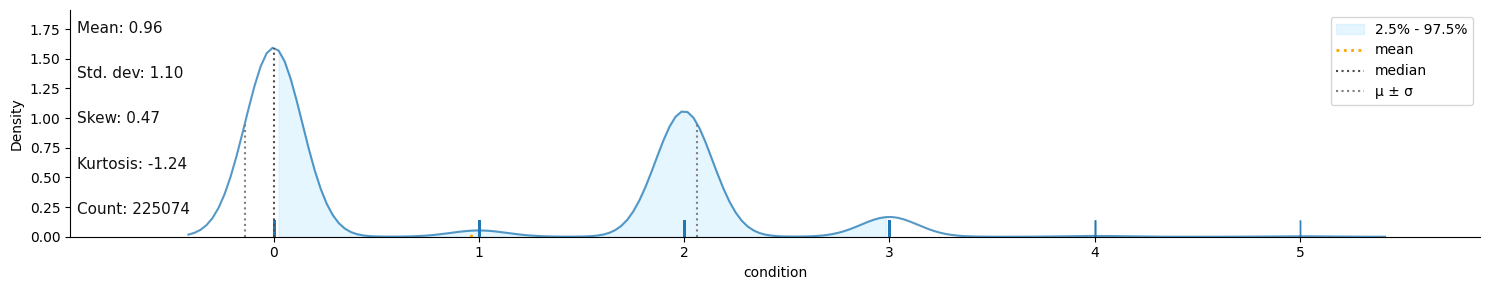

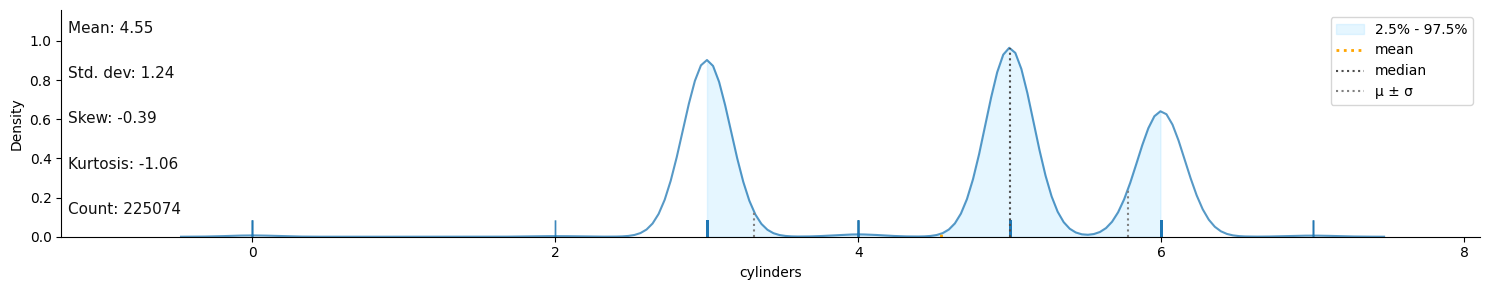

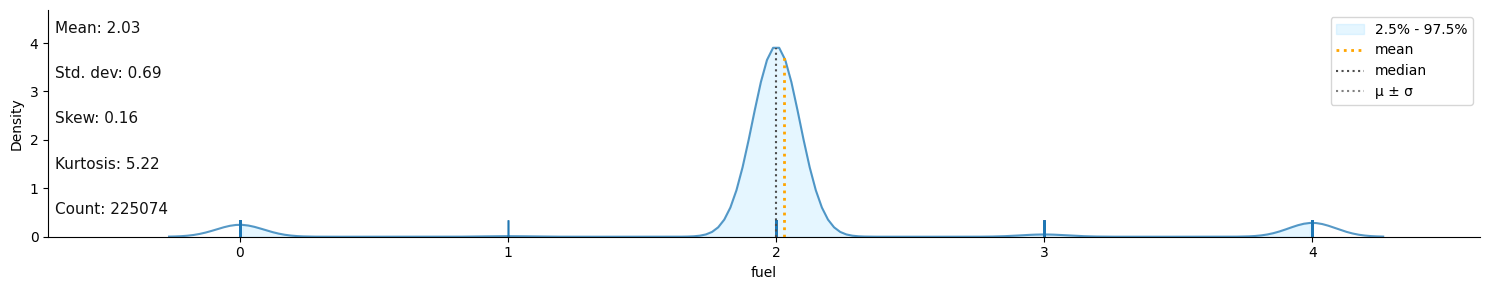

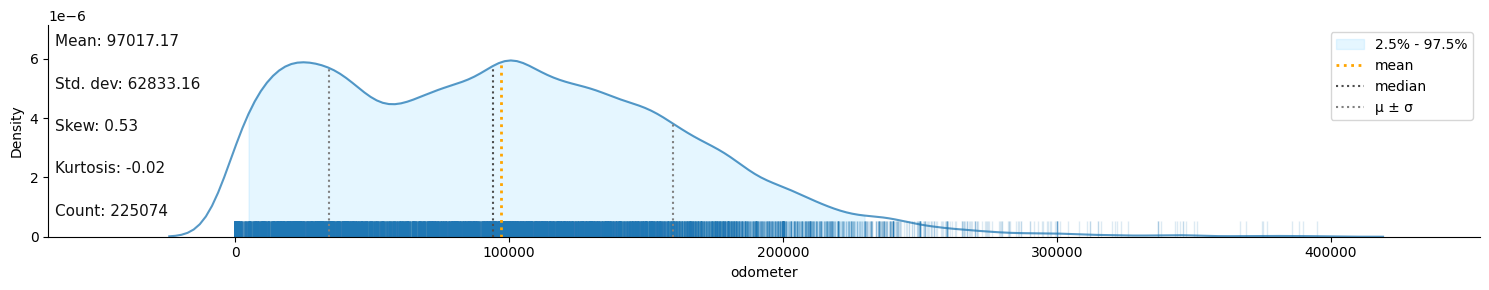

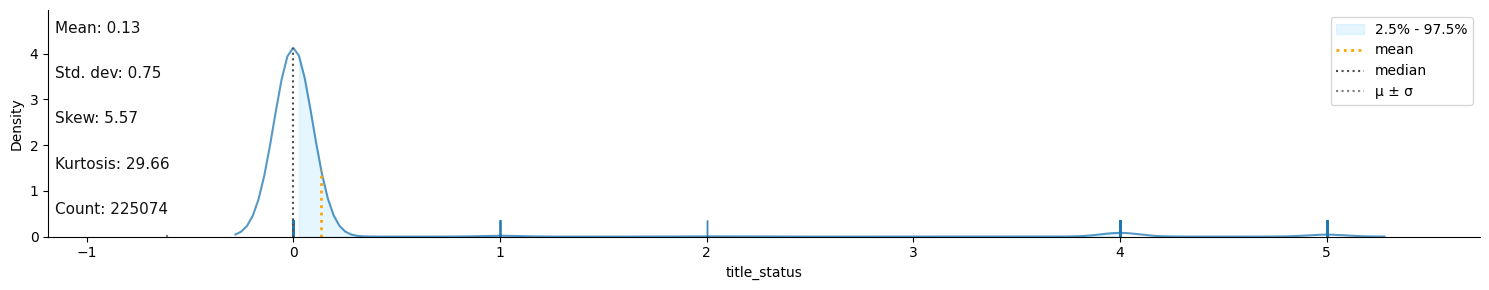

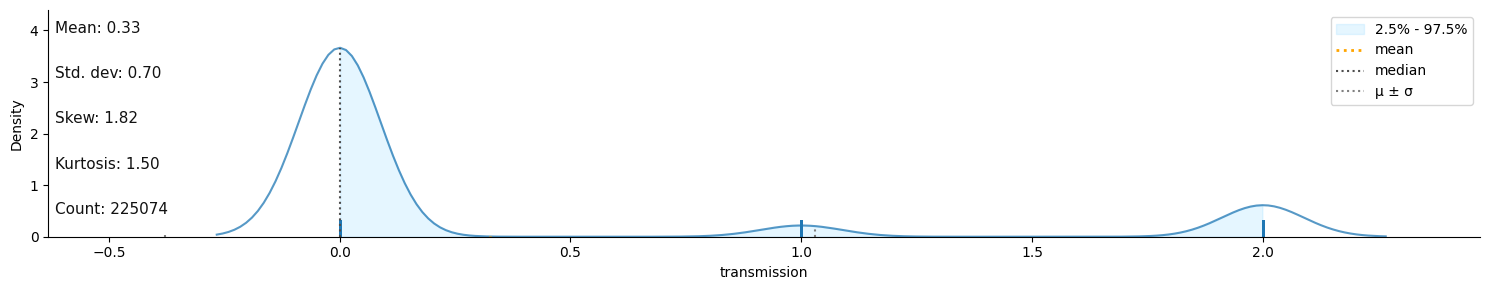

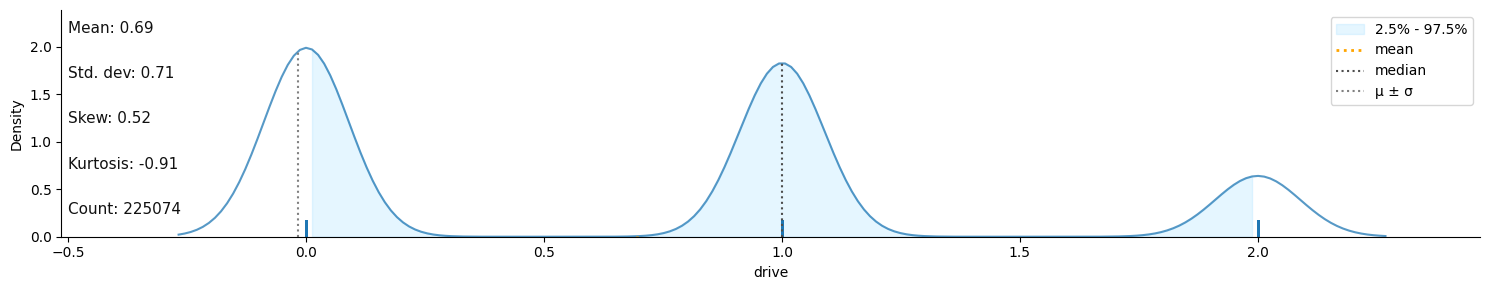

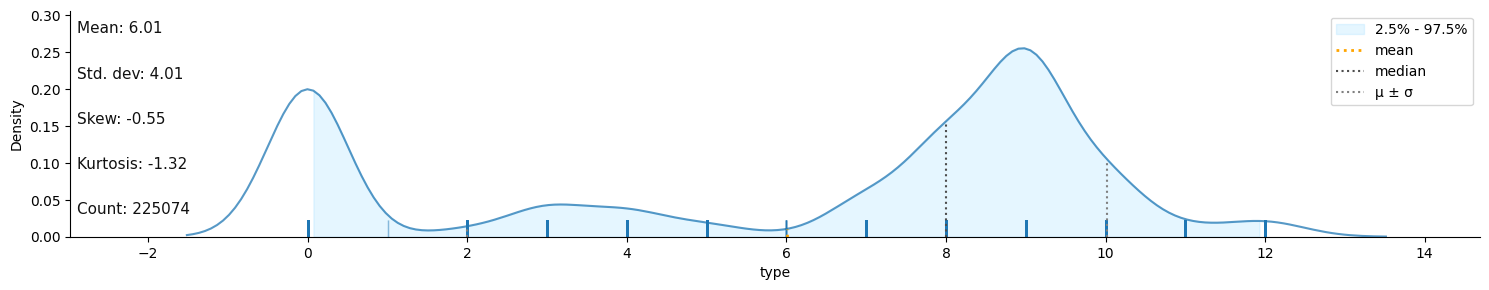

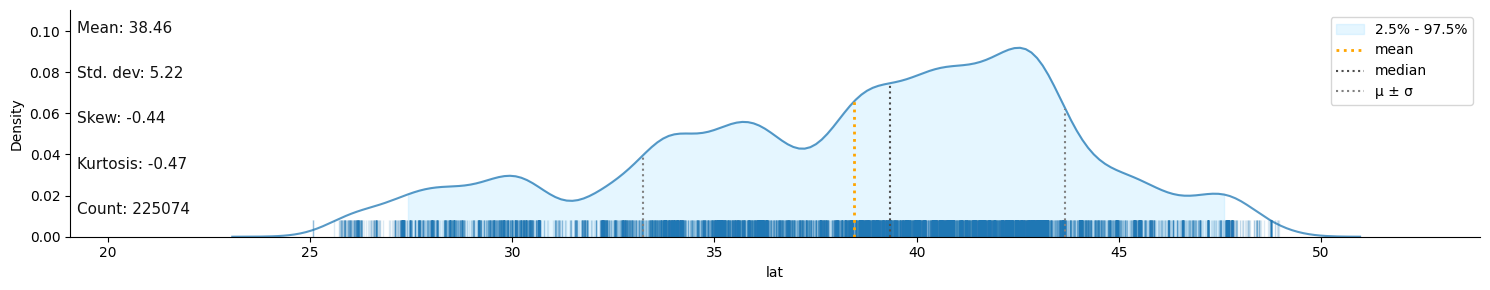

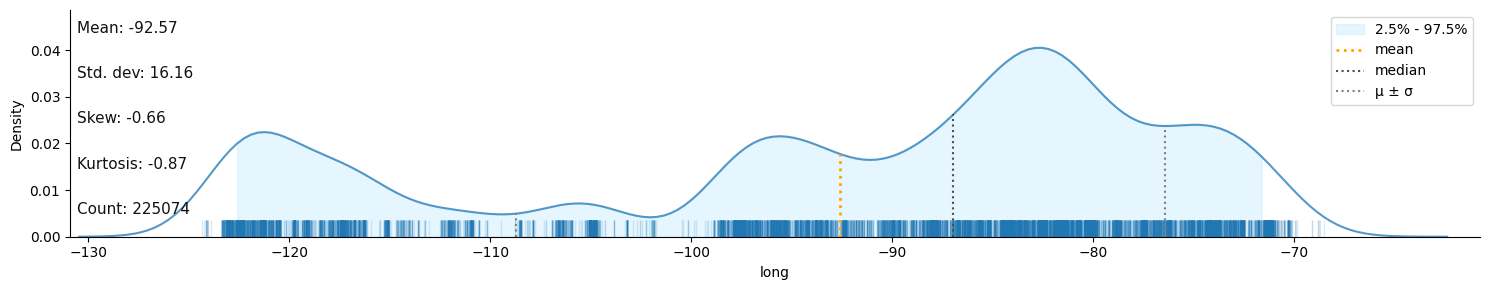

In [32]:
klib.dist_plot(data_clean)

# Modeling
---
Options:
- Linear Regression
- Nearest Neighbors Regression
- Bayesian Regression
- Decision Trees Regression
- Random Forest Regression

Something I've included were benchmarks I hit as I was working on this project

I didn't do too much hyperparameter tuning, I tested some but only showed minimal changes.

In [33]:
from sklearn.model_selection import train_test_split

X = data_clean.drop('price', axis=1)
y = data_clean['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

#### Linear Regression

Initially Linear Regression had 32% accuracy. As I improved my data cleaning, it managed to get 58%

In [34]:
from sklearn.linear_model import LinearRegression

linReg = LinearRegression().fit(X_train, y_train)
y_linPred = linReg.predict(X_test)

print(linReg.score(X_test,y_test))

0.5830288280509281


#### Nearest Neighbors Regression

Nearest Neighbors Regression started at 56% but went up to 66%. I tried scaling up the number of neighbors it takes into account but that doesn't seem to place nice. The accuracy begins to drop off at anything above 2, and by the time you hit 15 it really tapers off towards <60%

In [35]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)
y_neighPred = neigh.predict(X_test)

print(neigh.score(X_test,y_test))

0.6659688055446609


#### Decision Tree Regression

This was one of the more promising models, although as we know decision trees are going to be better for classification more often than not. It scored 73% in the beginning and ended at ~87% accuracy.

In [36]:
from sklearn.tree import DecisionTreeRegressor

decTreeReg = DecisionTreeRegressor()
decTreeReg.fit(X_train, y_train)
y_decTree = decTreeReg.predict(X_test)

print(decTreeReg.score(X_test, y_test))

0.8647443280002461


#### Bagging Regression

84.9% Accuracy on max_features=10 on its first iteration

The main hyperparameter adjustment made here is how many features its taking in at a time. How I have it setup currently is with max_features ranging from [6-13]. As you can see, 12 features gives the best result. I'll be taking that as the accuracy for this regressor.

Accuracy with 12 features: 92.598%



In [37]:
from sklearn.ensemble import BaggingRegressor
for features in [6,7,8,9,10,11,12,13]:

  regr1 = BaggingRegressor(max_features=features, random_state=9)
  regr1.fit(X_train, y_train)
  y_predBag = regr1.predict(X_test)

  print('Accuracy with',features,'features:',round(regr1.score(X_test,y_test)*100,3),'%')

Accuracy with 6 features: 87.035 %
Accuracy with 7 features: 89.436 %
Accuracy with 8 features: 90.313 %
Accuracy with 9 features: 91.509 %
Accuracy with 10 features: 91.85 %
Accuracy with 11 features: 92.217 %
Accuracy with 12 features: 92.238 %
Accuracy with 13 features: 91.822 %


#### Random Forest Regression

Random Forest wasn't leading the charge at first. It and Bagging Regression are both very accurate models for this data. Random Forest started at around 84% accuracy (behind Bagging Regression)

By the end it was on top at 92.947% accuracy.

I've tried to mess with the hyper-parameters here but it doesn't seem to make any difference, oftentimes reducing the accuracy of the model, or just reducing the efficiency excessively

In [38]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=100, random_state=9)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('Accuracy with 100 estimators:', round(regressor.score(X_test,y_test)*100,3),'%')

Accuracy with 100 estimators: 92.614 %


# Conclusion


---


So by the end the model was predicting prices pretty accurately. I didn't have much of a hypothesis here since this kind of problem just gives way to a solution more than experimentation. I'd say it could be implemented into a production setting, but probably not as is. The main concern here is to what degree the accuracy measures. Something I never looked into was how close is considered good in the score function. Its possible that value is too far from reality to be useful. For its usefulness, a model like such could be used at dealerships to get a sense of what should a vehicle be listed at, or even by consumers, rather than basing price off intuition. Such models already exist, and I doubt this trumps those, but as an earlier iteration of what one of "those" models does, it does well. Doing that job, a model like this could alleviate pressure of salesmen to nail the right price to ensure profit.

For other approaches I could consider taking, there are a few. There were a few ideas I had I just didn't have the time nor skill to implement. A big one would be the mess around with the VIN number. It would be very nice to take in a VIN number and auto-fill missing values instead of playing a guessing game, or even just to validate vehicles aren't stolen if that is available. Additionally, and if the dataset was suitably large, splitting the data by manufacturer and creating models independetly would be a very interesting idea. Such a situation could provide much more useful insight into how model effects the price, or how manufacturers appreciate/depreciate over time on a whole. In terms of more specific ideas to what I would try, the first that comes to mind is splitting vehicles by 'class'. That is, exotic cars, sports cars, luxury cars, commuter cars, etc etc. Doing so could enable us to broaden the scope of what the model can do. I had to (indirectly) forgo exotics cars for instance, and I'm sure plenty of the luxury market was also cut off in the process. If we made a new feature to classify the vehicles to different classes perhaps a single model could be made that does it all.

In any case, I thought it did good, and I'm pretty happy with the result!